<a href="https://colab.research.google.com/github/ddlandim/monografy-ann-demand-prediction/blob/master/Experimentos_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Preprocessamento e Ajustes dos Dados**

#### **IMPORT E LOAD DE DADOS**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
plt.style.use('ggplot')
# PROCESSAMENTO
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
# MODELOS
from tensorflow import keras
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
df_file = "https://raw.githubusercontent.com/ddlandim/monografy-ann-demand-prediction/master/experimentos_monografia/input/Todos.csv"

df = pd.read_csv(df_file,index_col='DATA',parse_dates=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 514 entries, 2017-12-04 to 2019-12-16
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   SEMESTRE_1               514 non-null    int64  
 1   SEMESTRE_2               514 non-null    int64  
 2   SEGUNDA                  514 non-null    int64  
 3   TERCA                    514 non-null    int64  
 4   QUARTA                   514 non-null    int64  
 5   QUINTA                   514 non-null    int64  
 6   SEXTA                    514 non-null    int64  
 7   DISTANCIA_DIA_ANTERIOR   514 non-null    int64  
 8   DISTANCIA_DIA_POSTERIOR  514 non-null    int64  
 9   PERC_CONCLUSAO_SEM       514 non-null    float64
 10  PERC_CONCLUSAO_MES       514 non-null    float64
 11  PRESSAO_ATMOSFERICA      514 non-null    float64
 12  TEMPERATURA              514 non-null    float64
 13  UMIDADE                  514 non-null    int64  
 14  VENTO  

In [ ]:
print(df.columns)

Index(['SEMESTRE_1', 'SEMESTRE_2', 'SEGUNDA', 'TERCA', 'QUARTA', 'QUINTA',
       'SEXTA', 'DISTANCIA_DIA_ANTERIOR', 'DISTANCIA_DIA_POSTERIOR',
       'PERC_CONCLUSAO_SEM', 'PERC_CONCLUSAO_MES', 'PRESSAO_ATMOSFERICA',
       'TEMPERATURA', 'UMIDADE', 'VENTO', 'VENDAS_ALMOCO', 'VENDAS_ALMOCO_1',
       'VENDAS_ALMOCO_2', 'VENDAS_ALMOCO_3', 'VENDAS_ALMOCO_4',
       'VENDAS_ALMOCO_5', 'ENTR_ALMOCO', 'ENTR_ALMOCO_1', 'ENTR_ALMOCO_2',
       'ENTR_ALMOCO_3', 'ENTR_ALMOCO_4', 'ENTR_ALMOCO_5', 'ENTR_JANTAR',
       'ENTR_JANTAR_1', 'ENTR_JANTAR_2', 'ENTR_JANTAR_3', 'ENTR_JANTAR_4',
       'ENTR_JANTAR_5'],
      dtype='object')


In [ ]:
df['ENTR_ALMOCO_1'][50] == df['ENTR_ALMOCO_2'][51]

True

#### **FUNÇÕES AUXILIARES**

In [ ]:
# plota serie
def plot_serie(serie, size=(12,4), title='Plot'):
    plt.figure(figsize=size)
    plt.title(title)
    plt.plot(serie)
    plt.show()

In [ ]:
# pega coluna dataframe['coluna_y'] e usa como y
# todas as outras colunas usa como x 
def to_supervised_numpy(dataframe, coluna_y):
    X = dataframe.loc[:, dataframe.columns != coluna_y].values # instantes de tempo passado (lags)
    Y = dataframe[coluna_y].values # valor atual para prever
    return np.array(X), np.array(Y)


In [ ]:
def plot_history(history, start_epoch=0):
    start_epoch = 10
    plt.figure(figsize=(10,4))
    plt.title('História Treino')
    plt.plot(history.history['loss'][start_epoch:], label='Train Loss')
    plt.plot(history.history['val_loss'][start_epoch:], label='Validation Loss')
    plt.legend()

#### **SPLIT TREINO / TESTE**

In [ ]:
# parametros divisao
validation_start = '2018-02-26' # primeiro dia 2018
test_start = '2019-02-20' # primeiro dia 2019
validation_semester = 'SEMESTRE_1'
# divide df completo
df_train = df[:validation_start]
df_val = df[validation_start:test_start]
df_test = df[test_start:]

print('Treino: {}'.format(len(df_train)))
print('Validação: {}'.format(len(df_val)))
print('Teste: {}'.format(len(df_test)))

Treino: 157
Validação: 188
Teste: 182


#### **FORMATANDO FEATURES TEMPORAIS PARA SHAPE COMPATÍVEL COM REDES RECORRENTES**
shape = (num_samples,   num_lags_passados,   num_features)

In [ ]:
# pegando features temporais
# IMPORTANTE ESTAR EM ORDEM !! PRIMEIRO ELEMENTO = Y E OS DEMAIS = X0, X1, ...
feature_0 = ['ENTR_ALMOCO', 'ENTR_ALMOCO_1', 'ENTR_ALMOCO_2','ENTR_ALMOCO_3', 'ENTR_ALMOCO_4', 'ENTR_ALMOCO_5',]
feature_1 = ['VENDAS_ALMOCO','VENDAS_ALMOCO_1','VENDAS_ALMOCO_2','VENDAS_ALMOCO_3','VENDAS_ALMOCO_4','VENDAS_ALMOCO_5']
feature_2 = ['ENTR_JANTAR','ENTR_JANTAR_1', 'ENTR_JANTAR_2', 'ENTR_JANTAR_3', 'ENTR_JANTAR_4','ENTR_JANTAR_5']
features_temporais = [feature_0, feature_1, feature_2]
##################################################
feature_to_predict = 0 # ENTR_ALMOCO, feature 0 que será o valor da saída do modelo (trocar se quiser)
##################################################
num_temporais = len(features_temporais) # 3 séries temporais


train_x, train_y = [], []
val_x, val_y = [], []
test_x, test_y = [], []
# serapando em dfs com somente uma feature
for feature_cols in features_temporais:
    # train
    x, y = to_supervised_numpy(df_train[feature_cols], feature_cols[0]) # feature[0] = ENTR_ALMOCO = y!!! IMPORTANTE  
    train_x.append(x); train_y.append(y)
    # validacao
    x, y = to_supervised_numpy(df_val[feature_cols], feature_cols[0]) # feature[0] = VENDAS_ALMOCO = y!!! IMPORTANTE  
    val_x.append(x); val_y.append(y)
    # test
    x, y = to_supervised_numpy(df_test[feature_cols], feature_cols[0]) # feature[0] = ENTR_JANTAR = y !!! IMPORTANTE  
    test_x.append(x); test_y.append(y)

    
# transforma em numpy array
train_x = np.array(train_x);  train_y = np.array(train_y); 
val_x = np.array(val_x);  val_y = np.array(val_y); 
test_x = np.array(test_x);  test_y = np.array(test_y); 
#
print('shape treino:', val_x.shape, val_y.shape)
print('shape validacao:', train_x.shape, train_y.shape)
print('shape teste:', test_x.shape, test_y.shape)

shape treino: (3, 188, 5) (3, 188)
shape validacao: (3, 157, 5) (3, 157)
shape teste: (3, 182, 5) (3, 182)


#### **TRATAMENTO DE OUTLIERS NAS FEATURES TEMPORAIS**
verifica se é distante da média

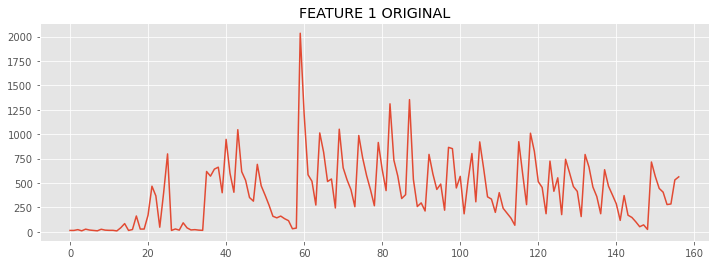

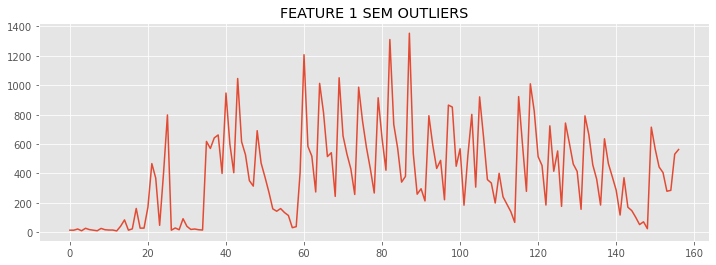

5 outliers  aredondados para a media


In [ ]:
TRATAR_OUTLIERS_NAS_FEATURES_TEMPORAIS = True
tolerancia_sigma = 3
num_outliers = 0
if TRATAR_OUTLIERS_NAS_FEATURES_TEMPORAIS:
    plot_serie(train_x[1, :, 0], title='FEATURE 1 ORIGINAL')
    num_outliers = 0
    for feature_i in range(num_temporais):
        desvio_padrao = np.std(train_x[feature_i, :, 0])
        media = np.mean(train_x[feature_i, :, 0])
        for lag_i in range(train_x.shape[2]):
            for element_i in range(train_x.shape[1]):
                valor = train_x[feature_i, element_i, lag_i]
                if np.abs(valor - media) >= tolerancia_sigma*desvio_padrao:
                    train_x[feature_i, element_i, lag_i] = media
                    num_outliers += 1
    
    plot_serie(train_x[1, :, 0], title='FEATURE 1 SEM OUTLIERS')
    print(num_outliers, 'outliers  aredondados para a media')

#### **ESCALONANDO FEATURES TEMPORAIS (MINMAX SCALER)**

Criados 3 scalers para as features temporais
(3, 5, 157, 1) (3, 157, 1)
(3, 5, 188, 1) (3, 188, 1)
(3, 5, 182, 1) (3, 182, 1)


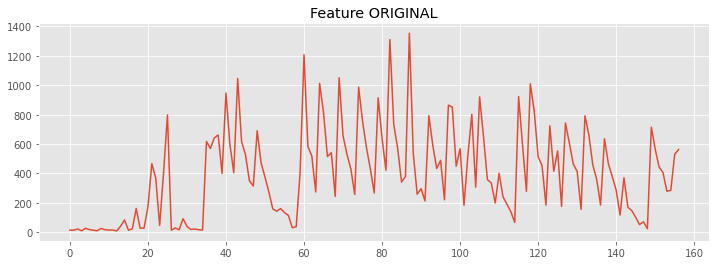

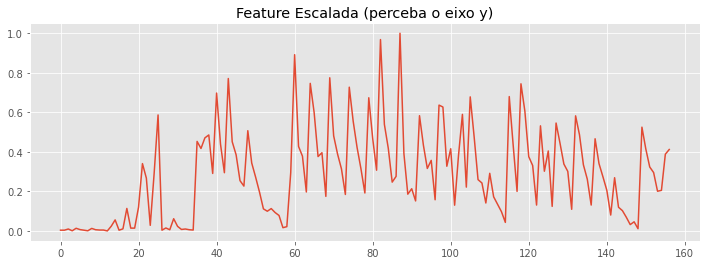

In [ ]:
#
# o correto seria escalonar antes de dividir em lags mas como ja foi dividido sera preciso
# fazer dessa forma não muito otimizada
# escalando features
scalers = [MinMaxScaler([0,1]) for i in range(num_temporais)] # Um scaler para cada feature TEMPORAL
print('Criados', len(scalers),'scalers para as features temporais')

# nao é a maneira mais eficiente, mas é a mais facil de implementar nessas condicoes

def treina_scalers(train_x):
    for i in range(len(train_x)): # pra cada feature
        feature_x = train_x[i]
        scalers[i].fit(feature_x[:, 0].reshape(-1,1)) # poderia usar qualquer coluna(lag), usando a primeira aqui
#     
def scala_features(data_x, data_y):
    scaled_data_x, scaled_data_y = [], []
    for feature_i in range(len(data_x)): # pra cada feature
        x = data_x[feature_i]; y = data_y[feature_i].reshape(-1, 1)
        scaled_x = []
        # pra cada lag, aplicar transform depois de ter 'treinado' o scaler(calculado parametros media etc)
        for lag in range(x.shape[1]): # x.shape[1] = numero de lags (nesse caso 5)
            lag_scaled = scalers[feature_i].transform(x[:, lag].reshape(-1,1)) # lag atual, ENTR_JANTAR_'lag' por exemplo
            scaled_x.append(lag_scaled) # adiciona cada lag no vetor de retorno, lag_1, lag_2 .. lag_5
        # scaled_x = vetor de lags para a feature do for mais externo, feature de indice feature_i
        scaled_data_x.append(np.array(scaled_x))
        scaled_data_y.append(scalers[feature_i].transform(y))
    return np.array(scaled_data_x), np.array(scaled_data_y)


# treina
treina_scalers(train_x) # treina os scalers para depois usar
# fit transform
scaled_train_x, scaled_train_y = scala_features(train_x, train_y)
scaled_val_x, scaled_val_y = scala_features(val_x, val_y)
scaled_test_x, scaled_test_y = scala_features(test_x, test_y)


# (num_features, num_lags, num_samples, 1) e (num_features, num_samples, 1)
print(scaled_train_x.shape, scaled_train_y.shape)
print(scaled_val_x.shape, scaled_val_y.shape)
print(scaled_test_x.shape, scaled_test_y.shape)

#
feature_para_ver = 1
plot_serie(train_x[feature_para_ver, :, 0], title='Feature ORIGINAL')
plot_serie(scaled_train_x[feature_para_ver, 0, :, 0], title='Feature Escalada (perceba o eixo y)')


#### **TRANSPONDO MATRIZES (SÓ UMA CONVENÇÃO, NÃO ALTERA NADA)**
Transpõe matrizes para ordem correta dos eixos
* Shape de Antes: **data_X:(num_features, num_lags, num_instancias, 1) data_Y:(num_features, num_instancias, 1)**
* Shape de Depois: **data_X:(num_instancias, num_lags, num_features) data_Y:(num_instancias, num_features)**

In [ ]:
def transpose_to_rnn(data_x, data_y): # faz a transposição (necessario devido ao problema citado acima)
    data_x = data_x.transpose(2, 1, 0, 3)
    data_y = data_y.transpose(1, 0, 2)
    data_x = np.squeeze(data_x) # remove ultima dimensão desnecessaria()
    data_y = np.squeeze(data_y) # remove ultima dimensão desnecessaria()

    return data_x, data_y
# sobreescreve matrizes , portanto executar uma única vez
scaled_train_x, scaled_train_y = transpose_to_rnn(scaled_train_x, scaled_train_y)
scaled_val_x, scaled_val_y = transpose_to_rnn(scaled_val_x, scaled_val_y)
scaled_test_x, scaled_test_y = transpose_to_rnn(scaled_test_x, scaled_test_y)
#
print(scaled_train_x.shape, scaled_train_y.shape)
print(scaled_val_x.shape, scaled_val_y.shape)
print(scaled_test_x.shape, scaled_test_y.shape)
#

(157, 5, 3) (157, 3)
(188, 5, 3) (188, 3)
(182, 5, 3) (182, 3)


#### **REMOVENDO Y QUE NÃO QUEREMOS PREVER DAS FEATURES TEMPORAIS(JANTA POR EXEMPLO)**


In [ ]:
# os vetores train_y, val_y e test_y possuem o y para todas as features
# porém queremos prever somente uma delas (saida da rede pode ser as tres caso quisermos)
# portanto vamos retirar as outras dos vetores y

# dados originais
train_y = train_y[feature_to_predict,:]
val_y = val_y[feature_to_predict,:]
test_y = test_y[feature_to_predict,:]
# dados escalados
scaled_train_y = scaled_train_y[:, feature_to_predict]
scaled_val_y = scaled_val_y[:, feature_to_predict]
scaled_test_y = scaled_test_y[:, feature_to_predict]
print(scaled_train_y.shape)
print(scaled_val_y.shape)
print(scaled_test_y.shape)

(157,)
(188,)
(182,)


#### **SEPARA FEATURES NÃO TEMPORAIS (ONE HOT E NUMERICAS)**


In [ ]:
# features one hot
features_categoricas = ['SEMESTRE_1', 'SEMESTRE_2']
# divide df completo
train_x_cat = df_train[features_categoricas].values
val_x_cat = df_val[features_categoricas].values
test_x_cat = df_test[features_categoricas].values
print('features categoricas one_hot: ',train_x_cat.shape, val_x_cat.shape, test_x_cat.shape)




#features numericas pontuais
features_numericas_pontuais = ['DISTANCIA_DIA_ANTERIOR', 'DISTANCIA_DIA_POSTERIOR',
       'PERC_CONCLUSAO_SEM', 'PERC_CONCLUSAO_MES', 'PRESSAO_ATMOSFERICA',
       'TEMPERATURA', 'UMIDADE', 'VENTO']
# divide df completo
train_x_numpont = df_train[features_numericas_pontuais].values
val_x_numpont = df_val[features_numericas_pontuais].values
test_x_numpont = df_test[features_numericas_pontuais].values
print('features numericas pontuais:', train_x_numpont.shape, val_x_numpont.shape, test_x_numpont.shape)

features categoricas one_hot:  (157, 2) (188, 2) (182, 2)
features numericas pontuais: (157, 8) (188, 8) (182, 8)


#### **ESCALA FEATURES NÃO TEMPORAIS E COMPACTA EM UM UNICO VETOR**


In [ ]:
# scaler das features numericas não temporais (temperatura, umidade etc) 
# nesse caso pode usar um unico scaler (ele cria diferentes estatisticas para cada feature)
scaler_numpont = MinMaxScaler([0,1]).fit(train_x_numpont)
train_x_numpont = scaler_numpont.transform(train_x_numpont)
val_x_numpont = scaler_numpont.transform(val_x_numpont)
test_x_numpont = scaler_numpont.transform(test_x_numpont)

# concatena tudo pra alimentar parte densa do modelo
train_x_dense = np.hstack([train_x_numpont, train_x_cat])
val_x_dense = np.hstack([val_x_numpont, val_x_cat])
test_x_dense = np.hstack([test_x_numpont, test_x_cat])

print('treino', train_x_dense.shape)
print('validacao', val_x_dense.shape)
print('teste', test_x_dense.shape)

treino (157, 10)
validacao (188, 10)
teste (182, 10)


In [ ]:
# RESULTADO 
print(scaled_train_x.shape, ' e ', train_x_dense.shape)

(157, 5, 3)  e  (157, 10)


# **Definição e Treino de Modelos**

## TODO: EXPLORANDO O PROBLEMA (RODAR PRIMEIROS TREINOS)
 CRIAR UMA MLP PADRÃO (1 CAMADA 1 SAÍDA), CHEGANDO NELA TODAS AS FEATURES ESCALADAS
 DEIXA-LA PREPARADA PARA SER USADA PARA PREVISÕES ASSIM COMO AS OUTRAS
 ESTA MLP SERÁ USADA PARA EXPLORAR O DOMÍNIO DO PROBLEMA E REALIZAR PRIMEIROS TREINOS. 
 O MAIS IMPORTANTE AQUI É TER O DATASET CHEGANDO INTEIRO E ESCALADO.

In [ ]:
## INSIRA A MLP AQUI.

## **Modelos que usam somente dados endógenos**

In [ ]:
num_lags = scaled_train_x.shape[1] # ou = 5
num_features = scaled_train_x.shape[2] # ou = 3
num_output = 1 # saída é um unico numero escalar
learning_rate = 0.001 # bom valor

### model_rnn_unique_1

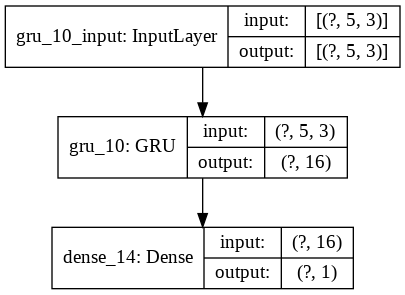

In [ ]:
#model_rnn_unique_1
###################### modelo RNN com uma única camada 
model_rnn_unique_1 = keras.Sequential()
num_units = 16 # ajustavel
model_rnn_unique_1.add(layers.GRU(num_units, input_shape=(num_lags, num_features),))
model_rnn_unique_1.add(layers.Dense(num_output, activation='linear'))
model_rnn_unique_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(model_rnn_unique_1, show_shapes=True)
######################

### model_rnn_unique_2

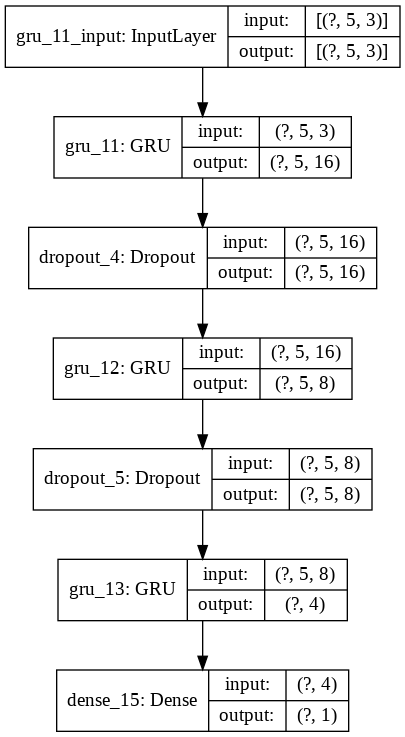

In [ ]:
#model_rnn_unique_2
###################### modelo RNN com mais de uma camada
model_rnn_unique_2 = keras.Sequential()
num_units = 16 # ajustavel
num_units_2 = 8 # ajustavel
num_units_3 = 4 # ajustavel
model_rnn_unique_2.add(layers.GRU(num_units, input_shape=(num_lags, num_features), return_sequences=True)) # return_sequences=True
model_rnn_unique_2.add(layers.Dropout(0.2)) # não necessário porém é bom
model_rnn_unique_2.add(layers.GRU(num_units_2, return_sequences=True))
model_rnn_unique_2.add(layers.Dropout(0.2)) # não necessário porém é bom
model_rnn_unique_2.add(layers.GRU(num_units_3, return_sequences=False)) # return_sequences=False
model_rnn_unique_2.add(layers.Dense(num_output, activation='linear'))


model_rnn_unique_2.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(model_rnn_unique_2, show_shapes=True)
###################### 

### model_mlp_unique_1

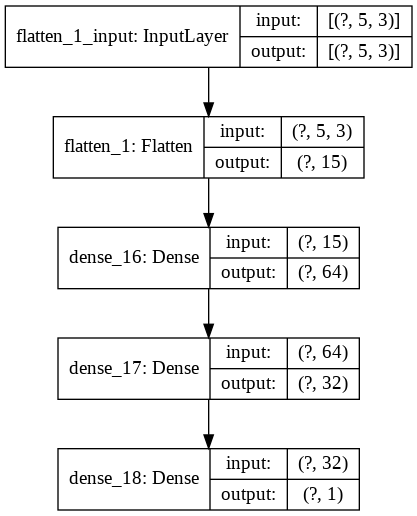

In [ ]:
#model_mlp_unique_1
###################### modelo MLP com uma única camada
model_mlp_unique_1 = keras.Sequential()
model_mlp_unique_1.add(layers.Flatten(input_shape=(num_lags, num_features),))
model_mlp_unique_1.add(layers.Dense(64, activation='relu'))
model_mlp_unique_1.add(layers.Dense(32, activation='relu'))
model_mlp_unique_1.add(layers.Dense(num_output, activation='linear'))
model_mlp_unique_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
              loss=keras.losses.mean_squared_error,
              metrics=[keras.losses.mean_squared_error])
keras.utils.plot_model(model_mlp_unique_1, show_shapes=True)
######################

###TREINO DOS MODELOS

###model_rnn_unique_1

(157, 5, 3) (157,)


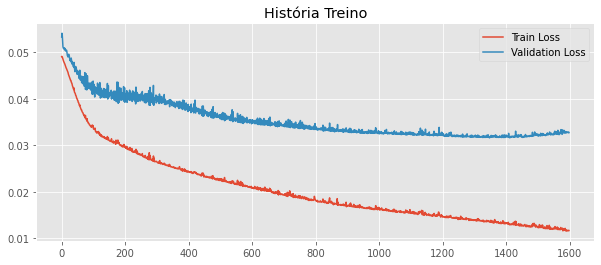

In [ ]:
#model_rnn_unique_1
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = model_rnn_unique_1.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

###model_rnn_unique_2

(157, 5, 3) (157,)


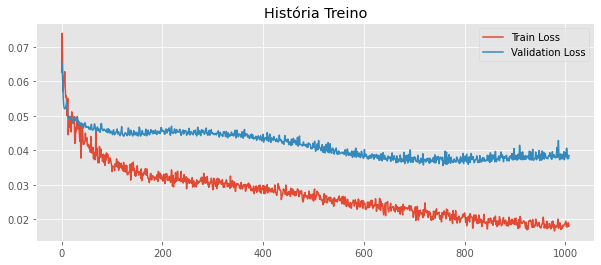

In [ ]:
#################################################################################
#################################################################################
#model_rnn_unique_2
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = model_rnn_unique_2.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

###model_mlp_unique_1

(157, 5, 3) (157,)


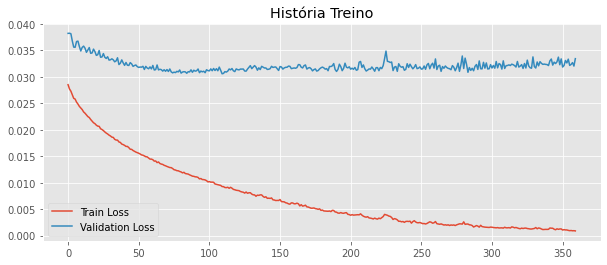

In [ ]:
#################################################################################
#################################################################################
#model_mlp_unique_1
print(scaled_train_x.shape, scaled_train_y.shape)
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, 
                   patience = 250, restore_best_weights=True)
history = model_mlp_unique_1.fit(
            scaled_train_x,
            scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = (scaled_val_x , scaled_val_y),
            callbacks=[es])
plot_history(history)

### **AVALIAÇÂO DO MODELO**

###model_rnn_unique_1

RMSE:  91.35647263043113


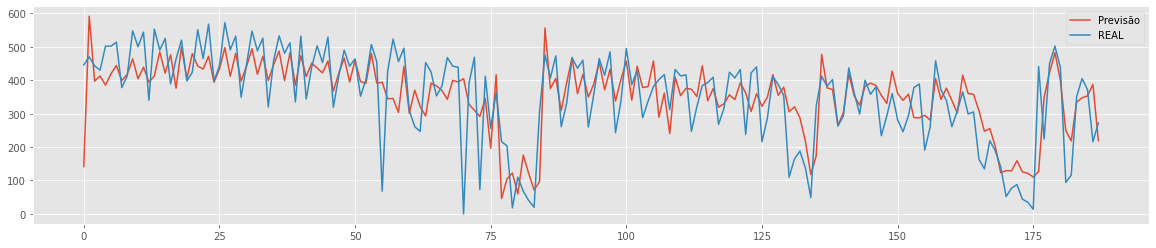

In [ ]:
#model_rnn_unique_1
pred_y = model_rnn_unique_1.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

###model_rnn_unique_2

RMSE:  96.92524922443646


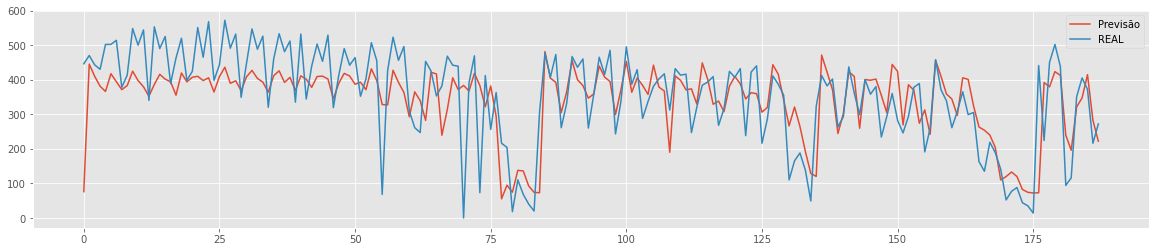

In [ ]:
#model_rnn_unique_2
pred_y = model_rnn_unique_2.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

###model_mlp_unique_1

RMSE:  89.86812539725703


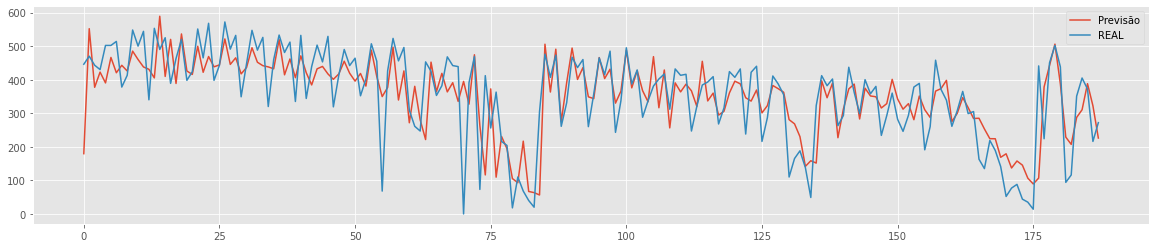

In [ ]:
#model_mlp_unique_1
pred_y = model_mlp_unique_1.predict(scaled_val_x)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
# original do problema para y
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

In [ ]:
#model.save('gru_32neur_semrelu.h5')

* **MSE Validação GRU 16 neuronios COM relu:** 9483., 9531., 7857.
* **MSE Validação GRU 16 neuronios SEM relu:** 7496., 7710., 8285.
* **MSE Validação GRU 32 neuronios com relu:** 7463., 7915., 8021.
* **MSE Validação GRU 32 neuronios SEM relu:** 7888., 7442., 8152.

## **Modelos que usam dados endógenos e exógenos**

In [ ]:
num_lags = scaled_train_x.shape[1] # ou = 5
num_features = scaled_train_x.shape[2] # ou = 3
num_dense_features = train_x_dense.shape[1]
num_output = 1
print('Numero de valores totais na entrada da rede:', num_lags * num_features + num_dense_features)

Numero de valores totais na entrada da rede: 25


#### **MULTIINPUT_MODEL_1 RNN e DENSO (multinput) - UMA CAMADA RNN E UMA DENSA**

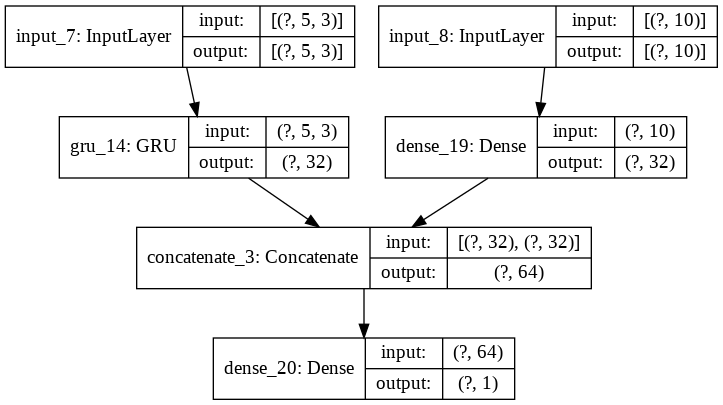

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(32, return_sequences=False)(input_layer_recorrente)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru, layer_dense])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
multiinput_model_1 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################



multiinput_model_1.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(multiinput_model_1, show_shapes=True)


#### **MULTIINPUT_MODEL_2 MODELO RNN e DENSO (multinput) - DUAS CAMADAS RNN e DUAS DENSAS (SEM DROPOUT)**

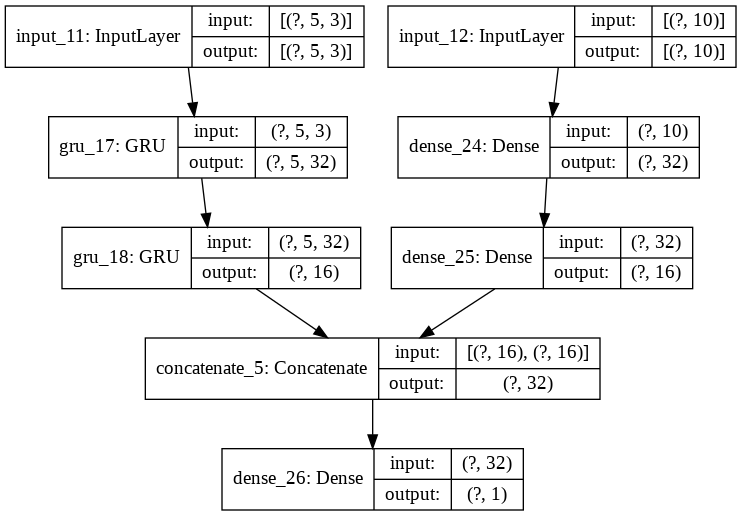

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(32, return_sequences=True)(input_layer_recorrente)

layer_gru_2 = layers.GRU(16, )(layer_gru)
# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense_2 = layers.Dense(16, activation='relu')(layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_gru_2, layer_dense_2])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
multiinput_model_2 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################



multiinput_model_2.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(multiinput_model_2, show_shapes=True)


#### **MULTIINPUT_MODEL_3 RNN e DENSO (multinput) - DUAS CAMADAS RNN e DUAS DENSAS (COM DROPOUT)**


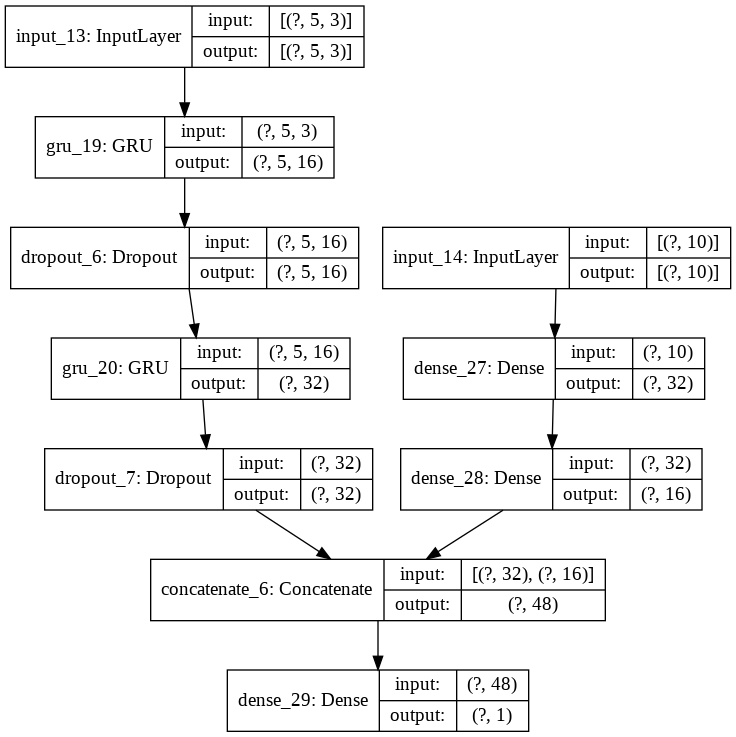

In [ ]:
learning_rate = 0.001
# parte recorrente da rede
input_layer_recorrente = layers.Input(shape=(num_lags, num_features))
layer_gru = layers.GRU(16, return_sequences=True)(input_layer_recorrente)
layer_dropout = layers.Dropout(0.2)(layer_gru)
layer_gru_2 = layers.GRU(32,)(layer_dropout)
layer_dropout_2 = layers.Dropout(0.2)(layer_gru_2)

# parte densa da rede
input_layer_dense = layers.Input(shape=(num_dense_features))
layer_dense = layers.Dense(32, activation='relu')(input_layer_dense)
layer_dense_2 = layers.Dense(16, activation='relu')(layer_dense)
# combina o output das duas partes
combined_layers = layers.concatenate([layer_dropout_2, layer_dense_2])
# output
output_layer = layers.Dense(num_output, activation='relu')(combined_layers)
### cria modelo 
multiinput_model_3 = keras.Model(inputs=[input_layer_recorrente, input_layer_dense], outputs=[output_layer])
######################



multiinput_model_3.compile(optimizer=keras.optimizers.Adam(learning_rate),
            loss=keras.losses.mean_squared_error)
keras.utils.plot_model(multiinput_model_3, show_shapes=True)


#### **TREINOS MODELOS MULTINPUT**

#### **multiinput_model_1**

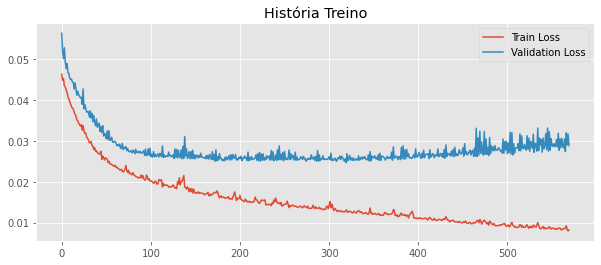

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = multiinput_model_1.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **multiinput_model_2**

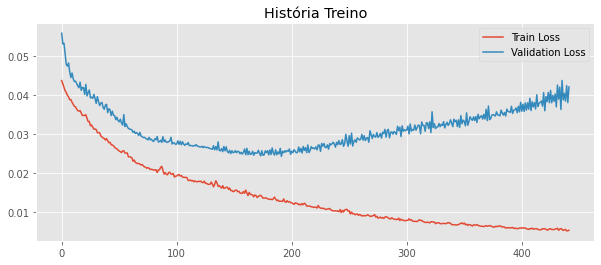

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = multiinput_model_2.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **multiinput_model_3**

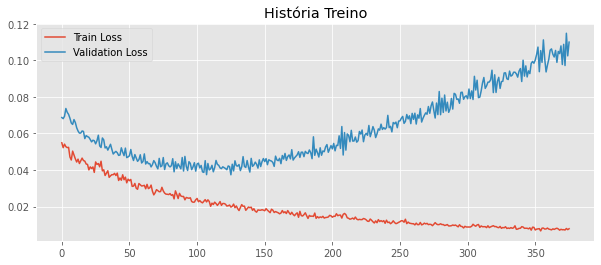

In [ ]:
# train
n_epochs = 2000 
# parada antecipada
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 0, patience = 250, restore_best_weights=True)
history = multiinput_model_3.fit(
            x=(scaled_train_x,train_x_dense), # tupla ao inves de vetor
            y=scaled_train_y,
            epochs = n_epochs, 
            verbose = 0,
            validation_data = ((scaled_val_x, val_x_dense) , scaled_val_y),
            callbacks=[es]
)
plot_history(history)

#### **AVALIAÇÂO DO MODELO**

#### **multiinput_model_1**

RMSE:  80.74959273176951


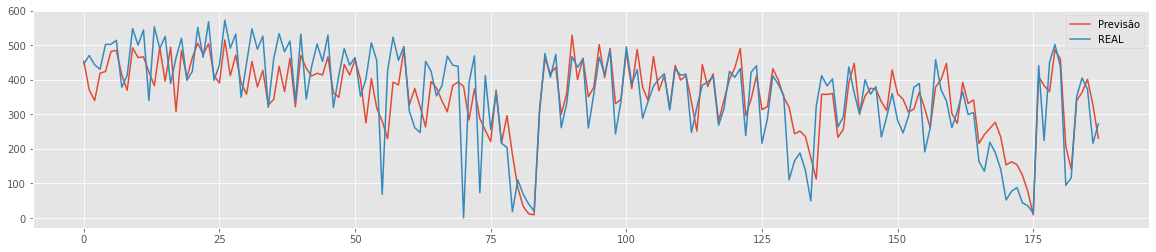

In [ ]:
x_validation = (scaled_val_x, val_x_dense)
pred_y = multiinput_model_1.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

#### **multiinput_model_2**

RMSE:  80.15877498691194


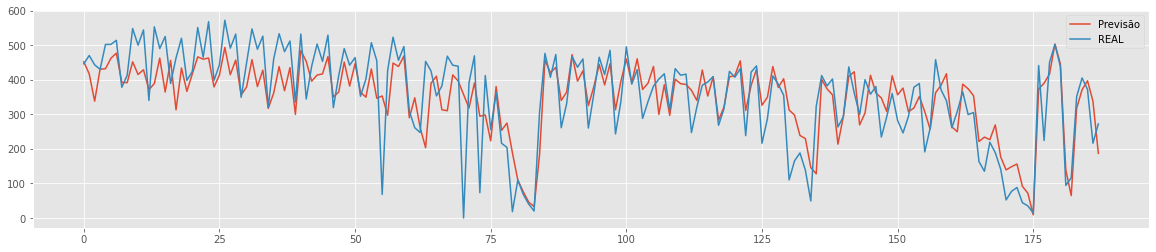

In [ ]:
x_validation = (scaled_val_x, val_x_dense)
pred_y = multiinput_model_2.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

#### **multiinput_model_3**

RMSE:  99.33831624055976


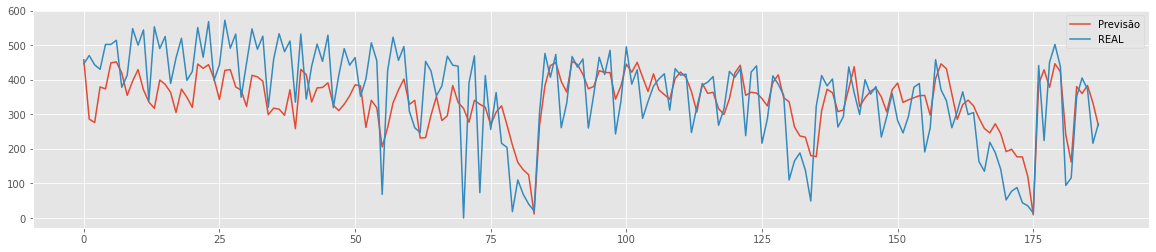

In [ ]:
x_validation = (scaled_val_x, val_x_dense)
pred_y = multiinput_model_3.predict(x_validation)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
val_y_original = scalers[feature_to_predict].inverse_transform(scaled_val_y.reshape(-1,1))
# calcula erros
mse = mean_squared_error(val_y_original, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

# **TESTE - FINAL**

#### **MODELOS SÓ COM FEATURES TEMPORAIS**
model_rnn_unique_1
model_rnn_unique_2
model_mlp_unique_2

#### **model_rnn_unique_1**

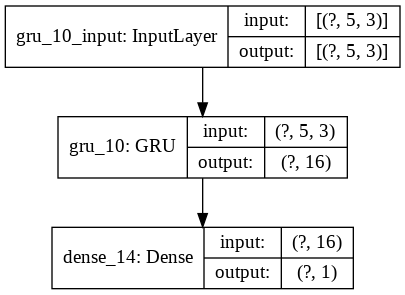

In [ ]:
keras.utils.plot_model(model_rnn_unique_1, show_shapes=True)

RMSE:  114.15074632752362


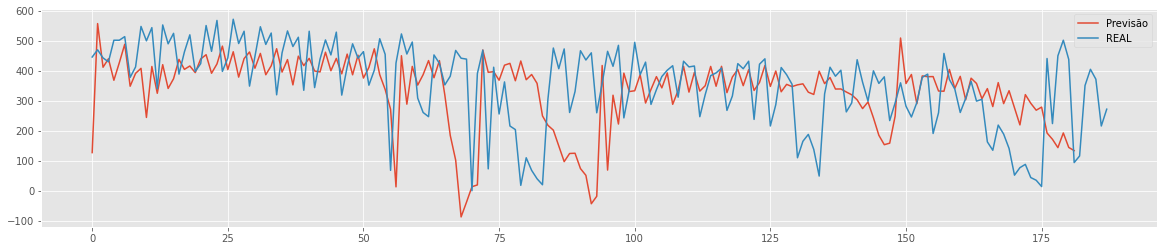

In [ ]:

x_test = scaled_test_x
pred_y = model_rnn_unique_1.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

#### **model_rnn_unique_2**

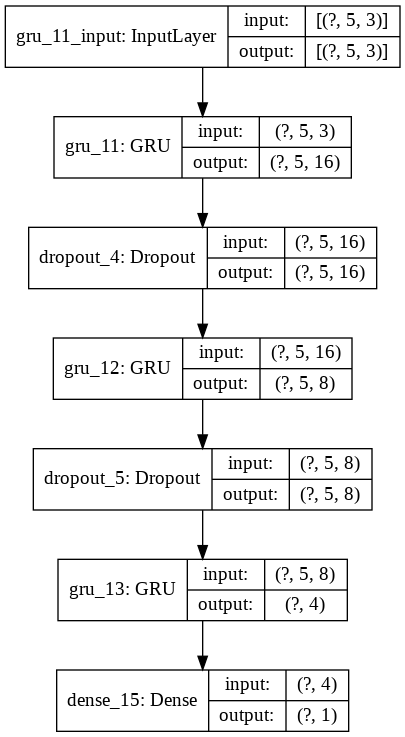

In [ ]:
keras.utils.plot_model(model_rnn_unique_2, show_shapes=True)

RMSE:  105.27310169533352


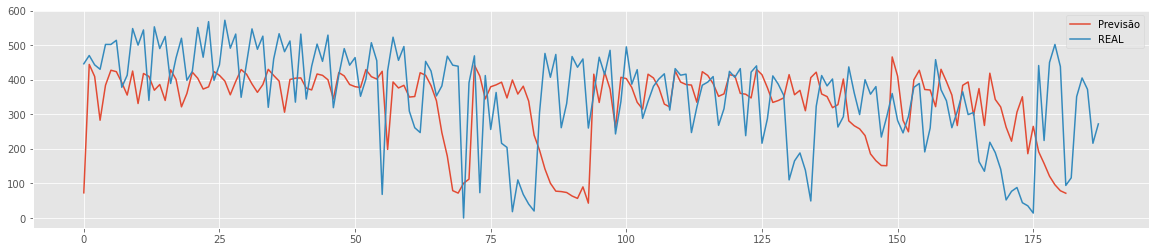

In [ ]:
x_test = scaled_test_x
pred_y = model_rnn_unique_2.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

#### **model_mlp_unique_1**

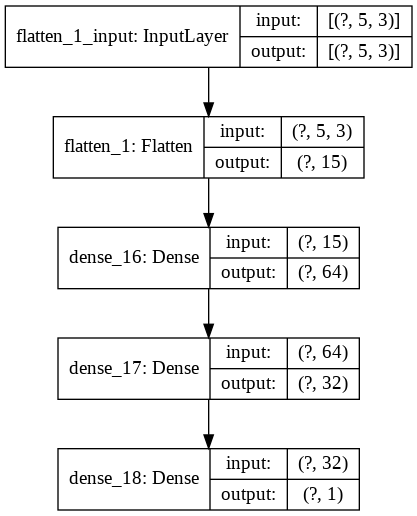

In [ ]:
keras.utils.plot_model(model_mlp_unique_1, show_shapes=True)

RMSE:  109.22389885280174


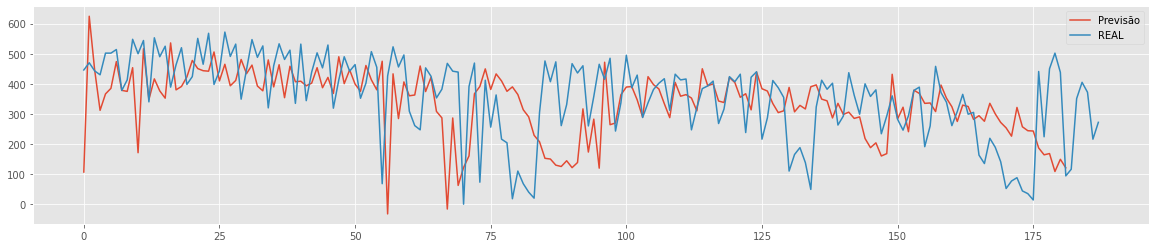

In [ ]:
x_test = scaled_test_x
pred_y = model_mlp_unique_1.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

#### **MULTI INPUT MODELS**
multiinput_model_1
multiinput_model_2
multiinput_model_3

#### **multiinput_model_1**

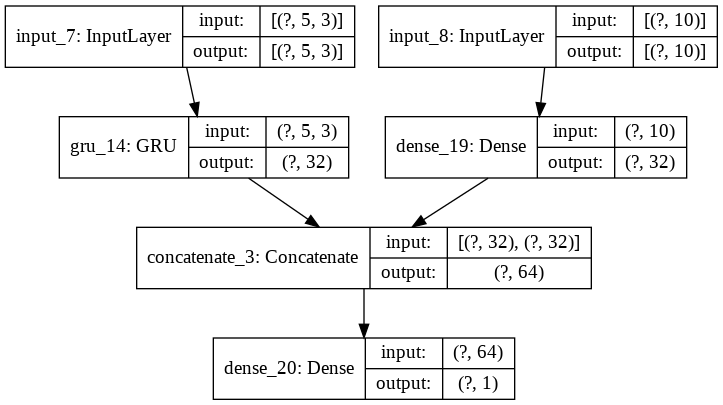

In [ ]:
keras.utils.plot_model(multiinput_model_1, show_shapes=True)

RMSE:  103.10609028194943


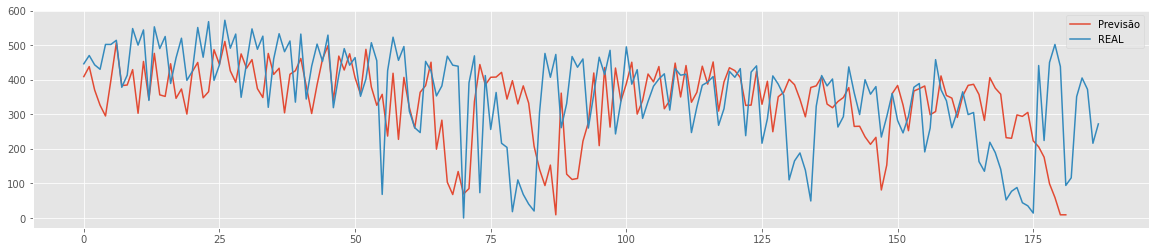

In [ ]:
x_test = (scaled_test_x, test_x_dense)
pred_y = multiinput_model_1.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

#### **multiinput_model2**

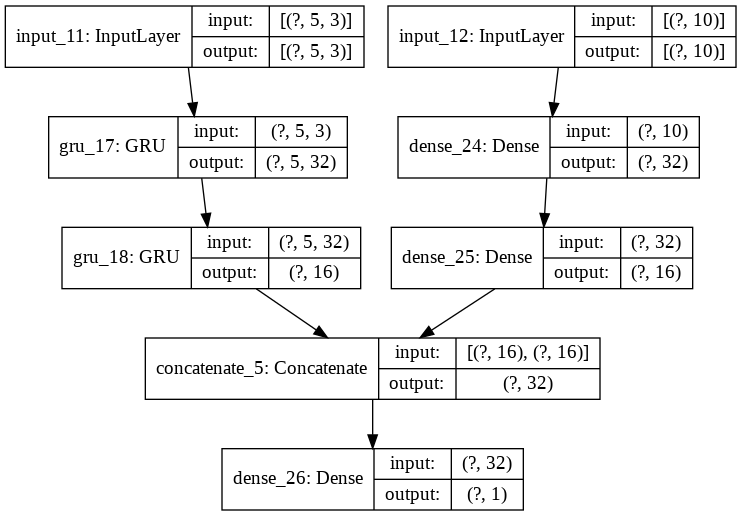

In [ ]:
keras.utils.plot_model(multiinput_model_2, show_shapes=True)

RMSE:  98.63473440332304


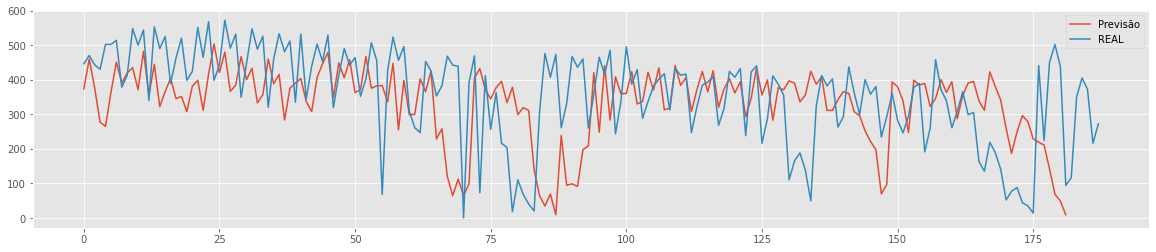

In [ ]:
x_test = (scaled_test_x, test_x_dense)
pred_y = multiinput_model_2.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)

# 
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()

#### **multiinput_model_3**

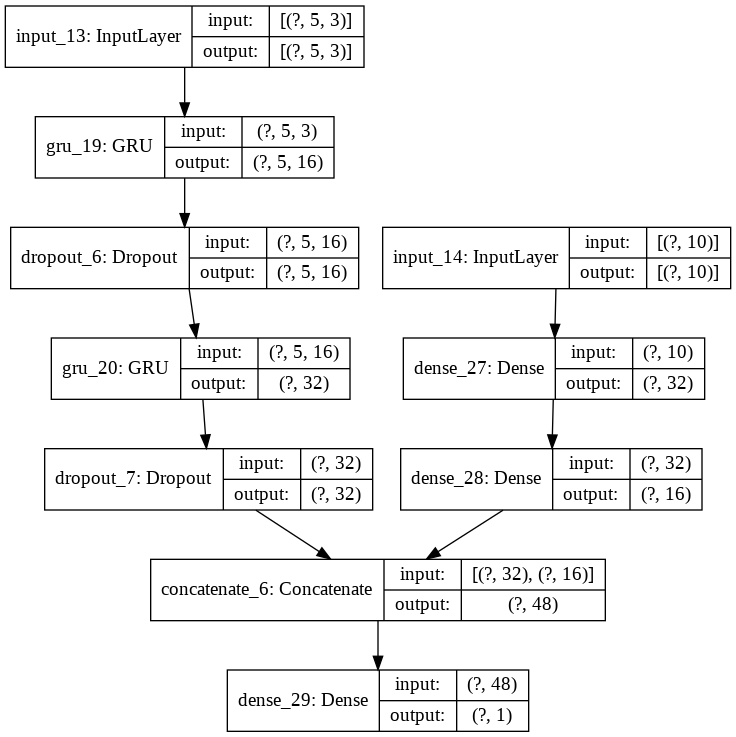

In [ ]:
keras.utils.plot_model(multiinput_model_3, show_shapes=True)

##TODO: APLICAR MÉTRICAS DE AVALIAÇÃO:

AJUSTAR: EM TODOS OS MODELOS A LINHA DE PREVISÃO ESTÁ ACABANDO ANTES DA LINHA REAL. 

CRIAR UMA FUNÇÃO PARA REALIZAR O QUE É FEITO NO BLOCO ABAIXO EM TODOS OS MODELO.

A FUNÇÃO PODE PEGAR O DATASET DE TESTE COM OS VALORES REAIS (QUE JÁ ESTÁ INDEXADO POR DATA E EM FORMATO PANDAS) E ACRESCENTAR AS COLUNAS: "PREDICTIONS", % DE ERRO, E % DE ERRO UNSIGNED ( PARAR TERMOSPONTO A PONTO, POIS POSSO CHAMAR A COLUNA DESTES ERROS E APLICAR UMA MÉDIA, OU MEDIANA, OU DESVIO PADRÃO). A MÉDIA DOS ERROS ABSOLUTOS SE CHAMA MAPE (MEDIDA IMPORTANTE)

QUILES PEDIU PARA EU SABER RECUPERAR A DATA DOS PONTOS ONDE HÁ COMPORTAMENTOS ANÔMALOS E EXPLICAR O QUE OCORRE (DIA ATÍPIDO DO CALENDÁRIO, FERIADO, ETC...)

RMSE:  107.85766592319293


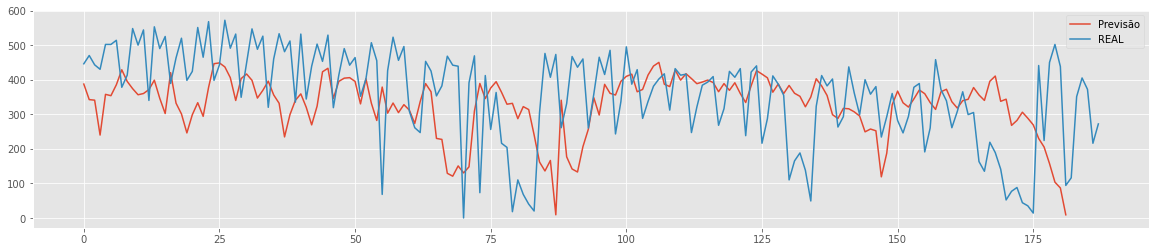

In [ ]:
x_test = (scaled_test_x, test_x_dense)
pred_y = multiinput_model_3.predict(x_test)
# retorna os valores a escala normal do problema
pred_y = scalers[feature_to_predict].inverse_transform(pred_y)
test_y_original = test_y
# calcula erros
mse = mean_squared_error(test_y, pred_y)
# .. outros erros
## plota grafico
print('RMSE: ', np.sqrt(mse))
plt.figure(figsize=(20,4))
plt.plot(pred_y, label='Previsão')
plt.plot(val_y_original, label='REAL')
plt.legend()
plt.show()